<a href="https://colab.research.google.com/github/semaHbo/ev-enerji-tahmini/blob/main/Feature_Engineering/Feature_Engineering2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kategorik degiskenleri sayisallastirma yapilacak buna bagli olarak veri seti tekrar ayni mantikla bölünerek ölceklendirme yapilacak. Bu islemler önceki dosyadan elde edilen bilgilere göre yapilacak

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/ev-enerji-tahmini/veri_seti_feature_engineering.csv', index_col='date', parse_dates=True)


In [4]:
from pandas.api.types import CategoricalDtype

# Kategori tiplerini tanımlama
mevsim_kategorileri = CategoricalDtype(categories=['Kis', 'Ilkbahar', 'Yaz', 'Sonbahar'], ordered=False)
gun_kategorileri = CategoricalDtype(categories=['Pzt', 'Salı', 'Çrş', 'Per', 'Cuma', 'Cmt', 'Paz'], ordered=False)
ay_kategorileri = CategoricalDtype(categories=['Ocak', 'Şubat', 'Mart', 'Nisan', 'Mayıs', 'Haziran',
                                               'Temmuz', 'Ağustos', 'Eylül', 'Ekim', 'Kasım', 'Aralık'], ordered=False)

# Tip dönüşümü
df['Mevsim'] = df['Mevsim'].astype(mevsim_kategorileri)
df['HaftaGunu_Adi'] = df['HaftaGunu_Adi'].astype(gun_kategorileri)
df['Ay_Adi'] = df['Ay_Adi'].astype(ay_kategorileri)

# One-hot encoding islemi
df = pd.get_dummies(df, columns=['Mevsim', 'HaftaGunu_Adi', 'Ay_Adi'], drop_first=True)


In [5]:
df.drop(columns=['Yil', 'Gun_Ay'], inplace=True)
#yil hep 2016 icin gereksiz, gün önemli bir metrik degil

In [6]:
df.to_csv('/content/drive/MyDrive/ev-enerji-tahmini/veri_seti_feature_engineering2.csv')


In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
df = pd.read_csv('/content/drive/MyDrive/ev-enerji-tahmini/veri_seti_feature_engineering2.csv', index_col='date', parse_dates=True)


In [9]:
#veriyi setlere ayirma
train_parts, val_parts, test_parts = [], [], []

for (yil, ay), grup in df.groupby([df.index.year, df.index.month]):
    grup = grup.sort_index()
    toplam = len(grup)
    train_end = int(toplam * 0.7)
    val_end = train_end + int(toplam * 0.15)
    train_parts.append(grup.iloc[:train_end])
    val_parts.append(grup.iloc[train_end:val_end])
    test_parts.append(grup.iloc[val_end:])

df_train = pd.concat(train_parts)
df_val = pd.concat(val_parts)
df_test = pd.concat(test_parts)


In [10]:
#hedefi cikarma
y_train = df_train['Enerji_Tuketimi']
y_val = df_val['Enerji_Tuketimi']
y_test = df_test['Enerji_Tuketimi']

X_train = df_train.drop(columns=['Enerji_Tuketimi'])
X_val = df_val.drop(columns=['Enerji_Tuketimi'])
X_test = df_test.drop(columns=['Enerji_Tuketimi'])


In [11]:
#ölceklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# DataFrame'e çevirme
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled, index=X_val.index, columns=X_val.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)


In [12]:
train_scaled = X_train_scaled_df.copy()
train_scaled['Enerji_Tuketimi'] = y_train

val_scaled = X_val_scaled_df.copy()
val_scaled['Enerji_Tuketimi'] = y_val

test_scaled = X_test_scaled_df.copy()
test_scaled['Enerji_Tuketimi'] = y_test

# CSV olarak kaydetme
train_scaled.to_csv('/content/drive/MyDrive/ev-enerji-tahmini/train_scaled.csv')
val_scaled.to_csv('/content/drive/MyDrive/ev-enerji-tahmini/val_scaled.csv')
test_scaled.to_csv('/content/drive/MyDrive/ev-enerji-tahmini/test_scaled.csv')


Train seti boyutu: (13813, 38)
Train zaman aralığı: 2016-01-11 17:00:00 → 2016-05-19 17:20:00

Validation seti boyutu: (2958, 38)
Validation zaman aralığı: 2016-01-25 21:50:00 → 2016-05-23 17:30:00

Test seti boyutu: (2964, 38)
Test zaman aralığı: 2016-01-28 22:50:00 → 2016-05-27 18:00:00


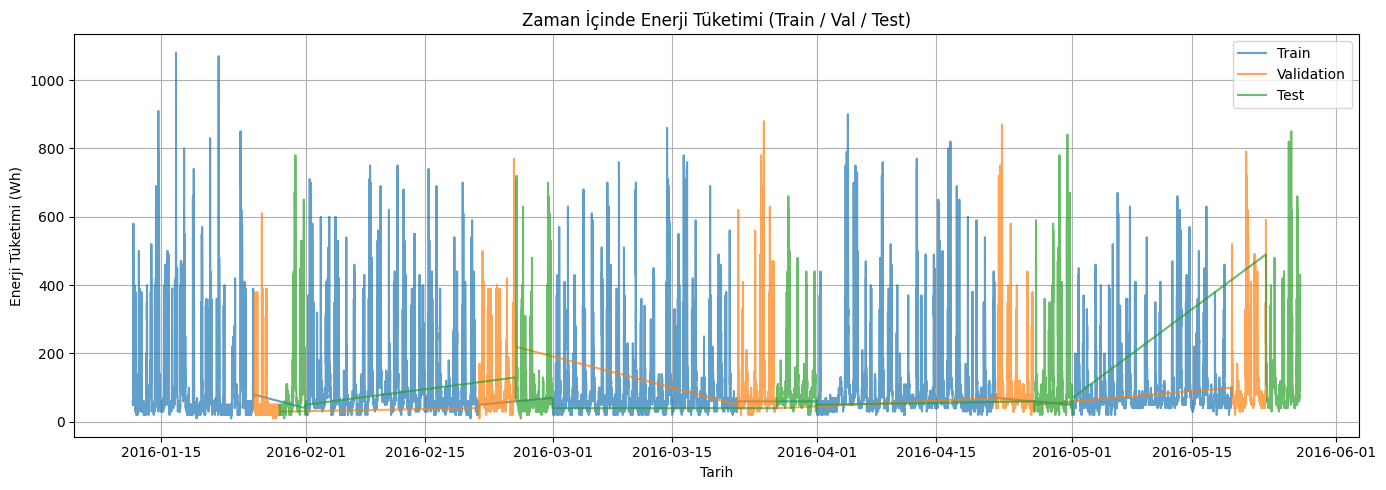

In [15]:
print("Train seti boyutu:", df_train.shape)
print("Train zaman aralığı:", df_train.index.min(), "→", df_train.index.max())

print("\nValidation seti boyutu:", df_val.shape)
print("Validation zaman aralığı:", df_val.index.min(), "→", df_val.index.max())

print("\nTest seti boyutu:", df_test.shape)
print("Test zaman aralığı:", df_test.index.min(), "→", df_test.index.max())

# Grafik çizimi
plt.figure(figsize=(14, 5))
plt.plot(df_train.index, df_train['Enerji_Tuketimi'], label='Train', alpha=0.7)
plt.plot(df_val.index, df_val['Enerji_Tuketimi'], label='Validation', alpha=0.7)
plt.plot(df_test.index, df_test['Enerji_Tuketimi'], label='Test', alpha=0.7)

plt.title("Zaman İçinde Enerji Tüketimi (Train / Val / Test)")
plt.ylabel("Enerji Tüketimi (Wh)")
plt.xlabel("Tarih")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Sütunlar:
['Enerji_Tuketimi', 'Aydinlatma_Tuketimi', 'Sicaklik_DisKuzey', 'Nem_DisKuzey', 'Sicaklik_DisHava', 'Basinc', 'Nem_DisHava', 'Ruzgar_Hizi', 'Gorus_Mesafesi', 'CiyNoktasi_Sicakligi', 'Rastgele_Degisken_1', 'Rastgele_Degisken_2', 'Ay', 'HaftaGunu', 'Sicaklik_IcOrtalama', 'Nem_IcOrtalama', 'Saat', 'HaftaSonuMu', 'Mevsim_Ilkbahar', 'Mevsim_Yaz', 'Mevsim_Sonbahar', 'HaftaGunu_Adi_Salı', 'HaftaGunu_Adi_Çrş', 'HaftaGunu_Adi_Per', 'HaftaGunu_Adi_Cuma', 'HaftaGunu_Adi_Cmt', 'HaftaGunu_Adi_Paz', 'Ay_Adi_Şubat', 'Ay_Adi_Mart', 'Ay_Adi_Nisan', 'Ay_Adi_Mayıs', 'Ay_Adi_Haziran', 'Ay_Adi_Temmuz', 'Ay_Adi_Ağustos', 'Ay_Adi_Eylül', 'Ay_Adi_Ekim', 'Ay_Adi_Kasım', 'Ay_Adi_Aralık']

İlk 10 Gözlem:
                     Enerji_Tuketimi  Aydinlatma_Tuketimi  Sicaklik_DisKuzey  \
date                                                                           
2016-01-11 17:00:00               60                   30           7.026667   
2016-01-11 17:10:00               60                   30      

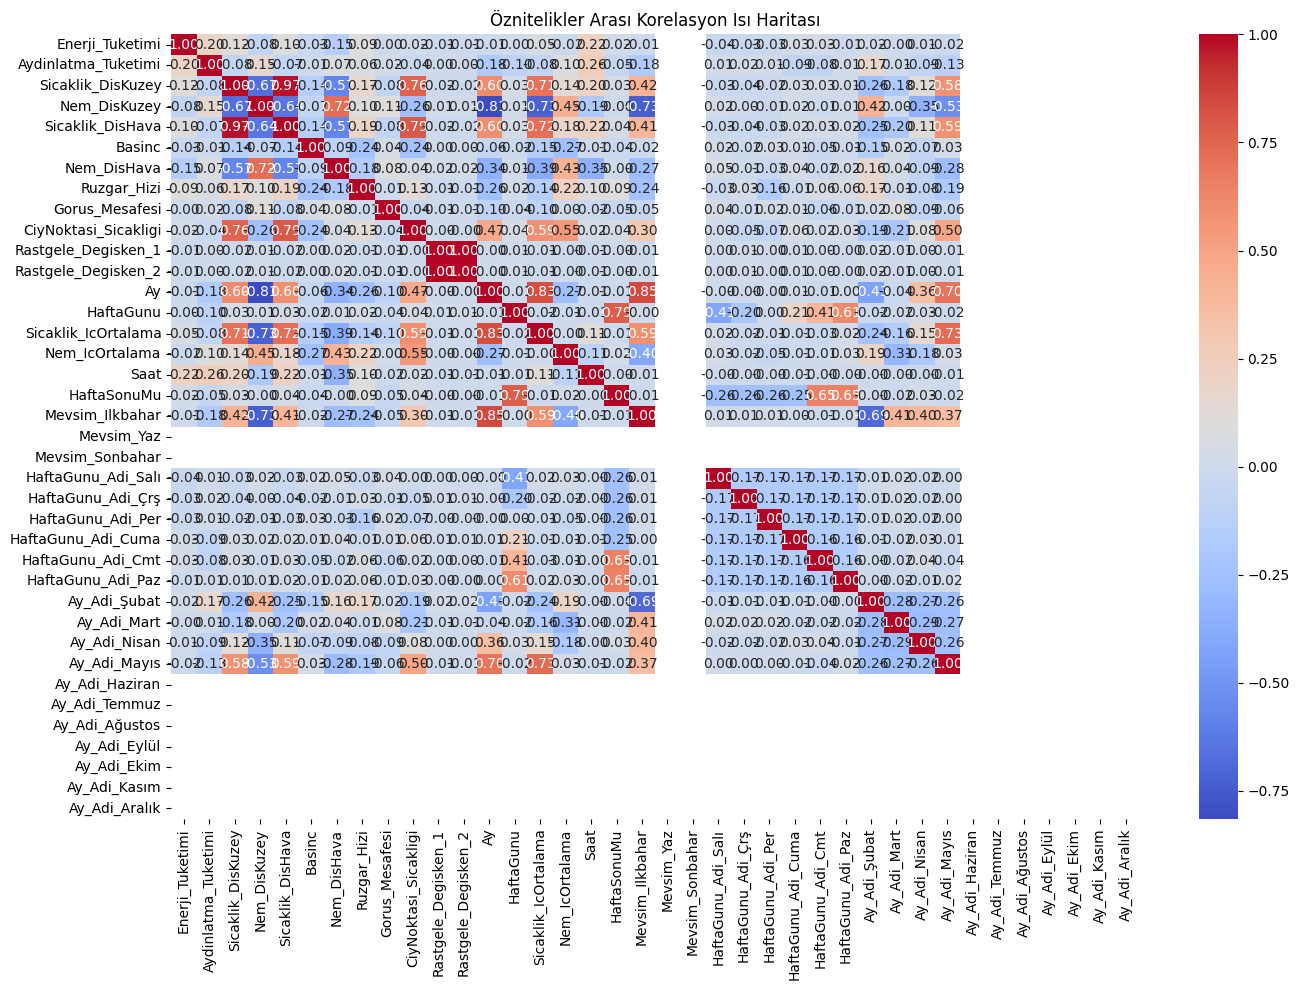

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sütunlar
print("Sütunlar:")
print(df.columns.tolist())

# İlk 10 satır
print("\nİlk 10 Gözlem:")
print(df.head(10))

# Korelasyon haritası
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Öznitelikler Arası Korelasyon Isı Haritası")
plt.tight_layout()
plt.show()


In [16]:
# Silinecek sütunlar
bos_sutunlar = [
    'Mevsim_Yaz', 'Mevsim_Sonbahar',
    'Ay_Adi_Haziran', 'Ay_Adi_Temmuz', 'Ay_Adi_Ağustos',
    'Ay_Adi_Eylül', 'Ay_Adi_Ekim', 'Ay_Adi_Kasım', 'Ay_Adi_Aralık'
]

df.drop(columns=bos_sutunlar, inplace=True)

print("Güncel sütun sayısı:", df.shape[1])


Güncel sütun sayısı: 29


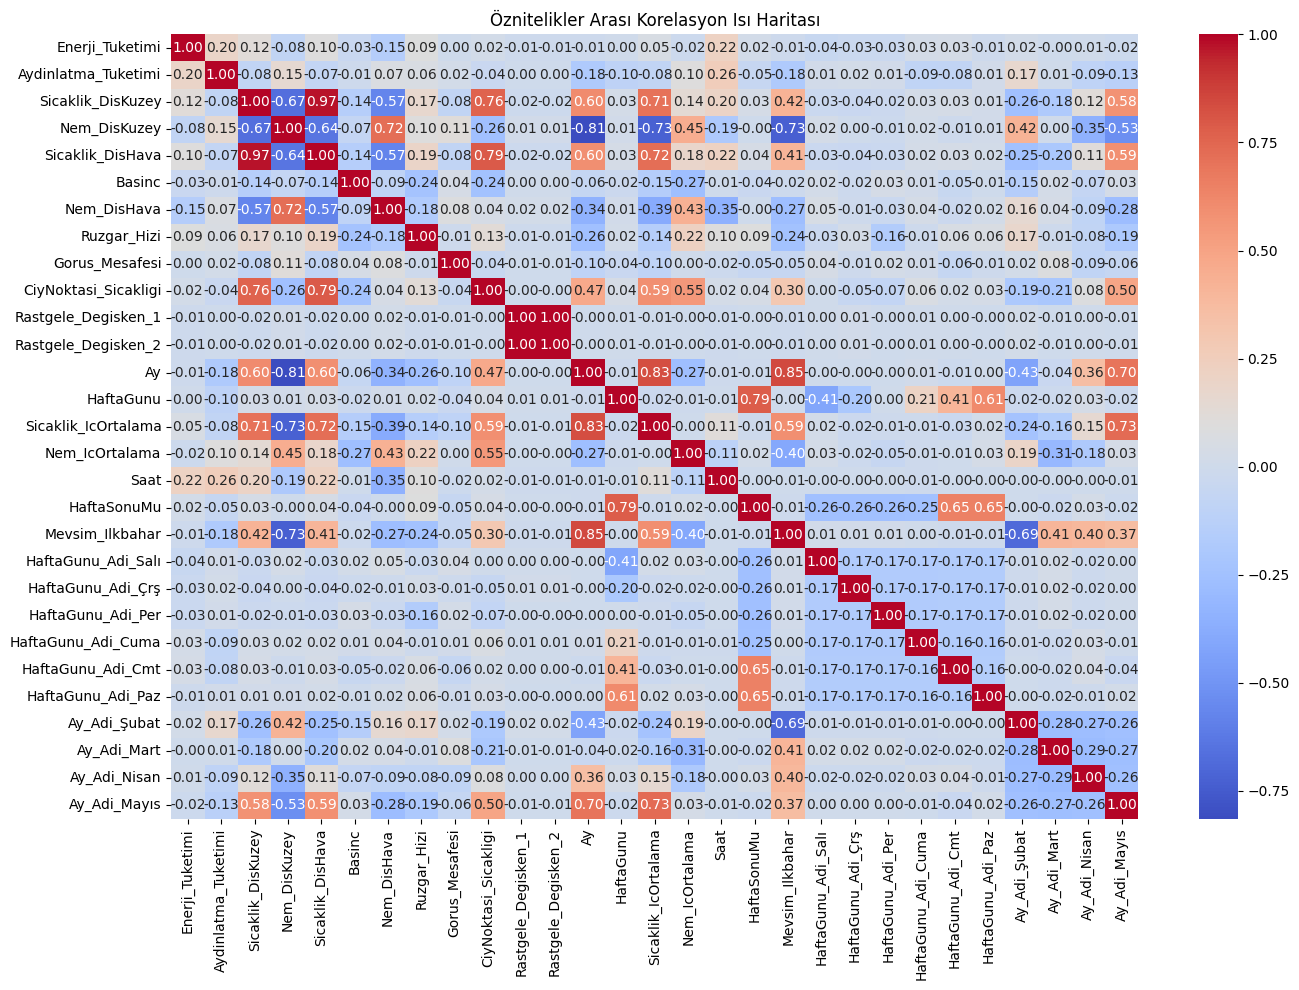

In [17]:
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Öznitelikler Arası Korelasyon Isı Haritası")
plt.tight_layout()
plt.show()

In [18]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/ev-enerji-tahmini/veri_seti_feature_engineering2.csv', index_col='date', parse_dates=True)


In [19]:
print("Güncel sütun sayısı:", df.shape[1])

Güncel sütun sayısı: 38


In [20]:
print("\n Veri seti boyutu:", df.shape)
print("\n Veri tipleri ve eksik değer durumu:")
display(df.info())
display(df.isnull().sum())


 Veri seti boyutu: (19735, 38)

 Veri tipleri ve eksik değer durumu:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Enerji_Tuketimi       19735 non-null  int64  
 1   Aydinlatma_Tuketimi   19735 non-null  int64  
 2   Sicaklik_DisKuzey     19735 non-null  float64
 3   Nem_DisKuzey          19735 non-null  float64
 4   Sicaklik_DisHava      19735 non-null  float64
 5   Basinc                19735 non-null  float64
 6   Nem_DisHava           19735 non-null  float64
 7   Ruzgar_Hizi           19735 non-null  float64
 8   Gorus_Mesafesi        19735 non-null  float64
 9   CiyNoktasi_Sicakligi  19735 non-null  float64
 10  Rastgele_Degisken_1   19735 non-null  float64
 11  Rastgele_Degisken_2   19735 non-null  float64
 12  Ay                    19735 non-null  int64  
 13  HaftaGunu       

None

,0
Enerji_Tuketimi,0
Aydinlatma_Tuketimi,0
Sicaklik_DisKuzey,0
Nem_DisKuzey,0
Sicaklik_DisHava,0
Basinc,0
Nem_DisHava,0
Ruzgar_Hizi,0
Gorus_Mesafesi,0
CiyNoktasi_Sicakligi,0


Olusturulmak istenen  grafik olusmadi islemler tekrar yapilacak